In [21]:
import numpy as np 
from scipy.stats import skew, kurtosis
from scipy.fft import fft
import numpy as np
import csv
import os 


from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report



class DataUtils():
    #---------------------------------------------
    #Load a file and returns it as a list
    #---------------------------------------------
    @staticmethod
    def loadFile(abs_path_to_file):
        """Load a .npy file."""
        obs=np.load(abs_path_to_file)
        return obs
    
    @staticmethod
    def extract_features_from_lst(meas_lst, label=""):
        fs=50000
        fft_coeffs = np.abs(fft(meas_lst))
        freq= np.fft.fftfreq(len(meas_lst), d=1 / fs)
        maxIdx = np.argmax(fft_coeffs[freq>=0])
        max_amplitude = fft_coeffs[maxIdx]
        dominant_frequency = freq[maxIdx]
        meas_lst=np.array(meas_lst, dtype=np.int64)
        return {
            f'mean_{label}': np.mean(meas_lst),
            f'std_{label}': np.std(meas_lst),
            f'min_{label}': np.min(meas_lst),
            f'max_{label}': np.max(meas_lst),
            f'energy_{label}': np.sum(np.square(meas_lst)),
            f'rootMeanSquare_{label}': np.sqrt(np.mean(np.square(meas_lst))),
            f'skewness_{label}': skew(meas_lst),
            f'kurtosis_{label}': kurtosis(meas_lst),
            f'fft_peak_amplitude_{label}': max_amplitude,
            f'fft_peak_frequency_{label}': dominant_frequency
        }
    @staticmethod
    def TrainTestFeaturesExtraction(df, fold, measType, mainDir):
        y_train=df[(df['Fold']==fold) & (df['Type']=="Train") ]['LabelIDs']
        x_train_files=df[(df['Fold']==fold) & (df['Type']=="Train") ]['FilePath']
        y_test=df[(df['Fold']==fold) & (df['Type']=="Test" )]['LabelIDs']
        x_test_files=df[(df['Fold']==fold) & (df['Type']=="Test") ]['FilePath']
        x_train_features=pd.DataFrame()
        x_test_features=pd.DataFrame()
        for files in x_train_files:
            array=np.transpose(DataUtils.loadFile(os.path.join(mainDir, files)))
            x_train_dict={}
            for i in range(0, len(array)):
                x_train_dict.update(DataUtils.extract_features_from_lst(array[:, i], label=measType[i]))
    
            x_train_features=pd.concat([x_train_features, pd.DataFrame([x_train_dict])], ignore_index=True)
    
        for files in x_test_files:
            array=np.transpose(DataUtils.loadFile(os.path.join(mainDir, files)))
            x_test_dict={}
            for i in range(0, len(array)):
                x_test_dict.update(DataUtils.extract_features_from_lst(array[:, i], label=measType[i]))
    
            x_test_features=pd.concat([x_test_features, pd.DataFrame([x_test_dict])], ignore_index=True)
        return x_train_features, x_test_features, y_train, y_test

    @staticmethod
     # Évaluation du modèle
    def model_evaluation(y_test, y_pred):
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)  # Dictionnaire contenant Precision, Recall, F1-score
        report_df=pd.DataFrame(report).transpose()
       
        conf_matrix = confusion_matrix(y_test, y_pred)  # Matrice de confusion
    
        return report_df, conf_matrix
    @staticmethod
    def padTruncate(mySig, maxTime, fs):
        """Pad or truncate the data to have a fixed duration.
        Args:
            mySig: the signal as a list
            maxTime: The maximum time in milliseconds.
            fs: the sampling rate in Hz    
            """
        sLen = mySig.shape[0]
        trunc=0
        maxLen=int(maxTime*int(fs/1000))
        if sLen > maxLen:
            trunc=1
            mySig = mySig[:, :maxLen]
        elif sLen < maxLen:
            trunc=-1
            mySig = np.pad(mySig, ((0, maxLen - sLen),(0,0)), mode='wrap')
        
        return (trunc, len(mySig), mySig)
    

In [23]:
import pandas as pd

myNpy="F:/Data_BachelorHES/5.Dataset_preparation/3.TrainsetBalancing/GlobalFoldsFiles_Train_Test_Augmented_Cleaned.csv"
myGlobalDs=pd.read_csv(myNpy)
myGlobalDs.drop(myGlobalDs.columns[myGlobalDs.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)


In [6]:
measType=['Sound', 'AccelX', 'AccelY', 'AccelZ']
mainDir="F:/Data_BachelorHES/5.Dataset_preparation/3.TrainsetBalancing"
x_trainFeat,  x_test_features, y_train, y_test  =DataUtils.TrainTestFeaturesExtraction(myGlobalDs, 0, measType, mainDir)

# TEST "BASIC" ML MODELS ON FEATURES FOR ALL FOLDS

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import RobustScaler



report_dict_naiveBayes={}
report_dict_knn={}
report_dict_dTree={}
report_dict_rForest={}

confMatrices_naiveBayes=[]
confMatrices_knn=[]
confMatrices_dTree=[]
confMatrices_rForest=[]

scaler = RobustScaler()
measType=['Sound', 'AccelX', 'AccelY', 'AccelZ']
myDir="F:/Data_BachelorHES/5.Dataset_preparation/3.TrainsetBalancing"
myResults=pd.DataFrame(columns=['Fold', 'Model', 'Accuracy'])

for fold in range(0,5):
    #Import of statistical features and scaling
    x_train_features, x_test_features, y_train, y_test = DataUtils.TrainTestFeaturesExtraction(myGlobalDs, fold, measType, myDir)
    X_train_scaled=scaler.fit_transform(x_train_features)
    X_test_scaled=scaler.transform(x_test_features)
    
    #Naive Bayes
    nb_model = GaussianNB()
    nb_model.fit(X_train_scaled,y_train)
    predicted= nb_model.predict(X_test_scaled)
    res=accuracy_score(y_test, predicted)
    myResults=pd.concat([myResults, pd.DataFrame([{'Fold':fold, 'Model':'Naive Bayes', 'Accuracy':res}])], ignore_index=True)
    report_dict_naiveBayes[f"Fold_{fold}"], conf_matrix=DataUtils.model_evaluation(y_test, predicted) 
    confMatrices_naiveBayes.append(conf_matrix)
    print(f"Naive Bayes for fold {fold}",accuracy_score(y_test, predicted))
    
    #KNN
    knn_model = KNeighborsClassifier()
    knn_model.fit(X_train_scaled,y_train)
    predicted= knn_model.predict(X_test_scaled)
    res=accuracy_score(y_test, predicted)
    myResults=pd.concat([myResults, pd.DataFrame([{'Fold':fold, 'Model':'KNN', 'Accuracy':res}])], ignore_index=True)
    report_dict_knn[f"Fold_{fold}"], conf_matrix=DataUtils.model_evaluation(y_test, predicted) 
    confMatrices_knn.append(conf_matrix)  
    print(f"KNN for fold {fold}",accuracy_score(y_test, predicted))
   
   #Decision Tree
    dtree_model = DecisionTreeClassifier()
    dtree_model.fit(X_train_scaled,y_train)
    dtree_predicted = dtree_model.predict(X_test_scaled)
    res=accuracy_score(y_test, predicted)
    myResults=pd.concat([myResults, pd.DataFrame([{'Fold':fold, 'Model':'Decision Tree', 'Accuracy':res}])],ignore_index=True) 
    report_dict_dTree[f"Fold_{fold}"], conf_matrix=DataUtils.model_evaluation(y_test, predicted) 
    confMatrices_dTree.append(conf_matrix)  
    print(f"Decision Tree for fold {fold}",accuracy_score(y_test, dtree_predicted))
    
    
    #Random Forest
    rfc_model = RandomForestClassifier(n_estimators = 100,random_state = 99)
    rfc_model.fit(X_train_scaled,y_train)
    predicted = rfc_model.predict(X_test_scaled)
    res=accuracy_score(y_test, predicted)
    myResults=pd.concat([myResults, pd.DataFrame([{'Fold':fold, 'Model':'Random Forest', 'Accuracy':res}])], ignore_index=True)
    report_dict_rForest[f"Fold_{fold}"], conf_matrix=DataUtils.model_evaluation(y_test, predicted) 
    confMatrices_rForest.append(conf_matrix)  
    print(f"Random Forest for fold {fold}",accuracy_score(y_test,predicted))
    
del fold, predicted, res, nb_model, knn_model, dtree_model, dtree_predicted, rfc_model

C:\Users\Julie\AppData\Local\Temp\ipykernel_17528\2774064610.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  myResults=pd.concat([myResults, pd.DataFrame([{'Fold':fold, 'Model':'Naive Bayes', 'Accuracy':res}])], ignore_index=True)


Naive Bayes for fold 0 0.17983651226158037
KNN for fold 0 0.2016348773841962
Decision Tree for fold 0 0.18528610354223432
Random Forest for fold 0 0.23978201634877383
Naive Bayes for fold 1 0.22343324250681199
KNN for fold 1 0.18256130790190736
Decision Tree for fold 1 0.22343324250681199
Random Forest for fold 1 0.25340599455040874
Naive Bayes for fold 2 0.17166212534059946
KNN for fold 2 0.17166212534059946
Decision Tree for fold 2 0.1880108991825613
Random Forest for fold 2 0.25885558583106266
Naive Bayes for fold 3 0.18528610354223432
KNN for fold 3 0.1553133514986376
Decision Tree for fold 3 0.14713896457765668
Random Forest for fold 3 0.23978201634877383
Naive Bayes for fold 4 0.17983651226158037
KNN for fold 4 0.17166212534059946
Decision Tree for fold 4 0.18528610354223432
Random Forest for fold 4 0.2016348773841962


In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(matrix, title="Confusion Matrix"):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    fig, ax = plt.subplots(figsize=(8, 8))  # Ajuste la taille si nécessaire
    disp.plot(ax=ax, cmap="Blues", values_format=".0f")
    ax.set_title(title)
    plt.show()


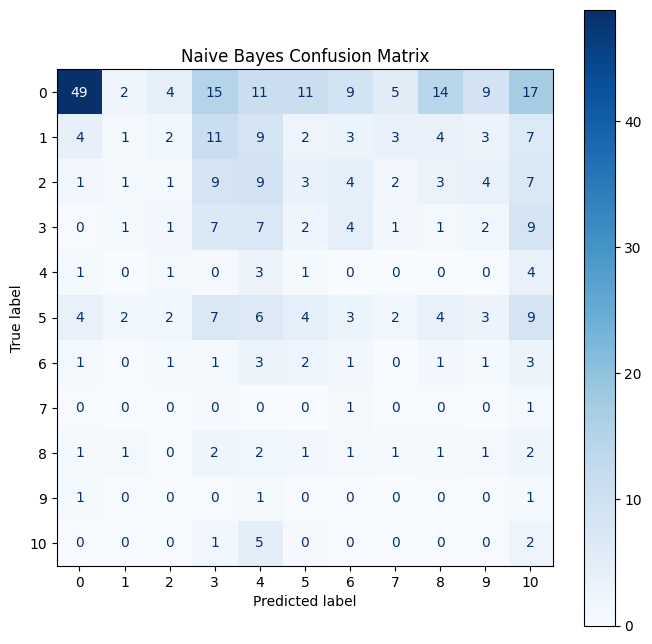

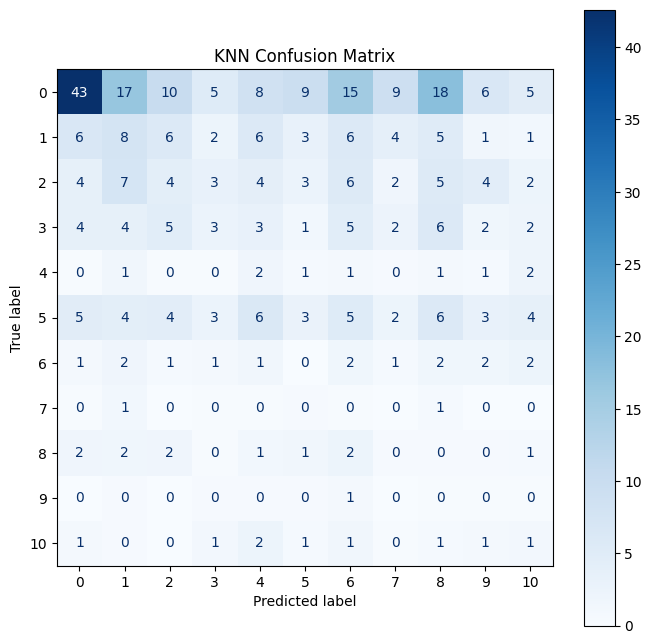

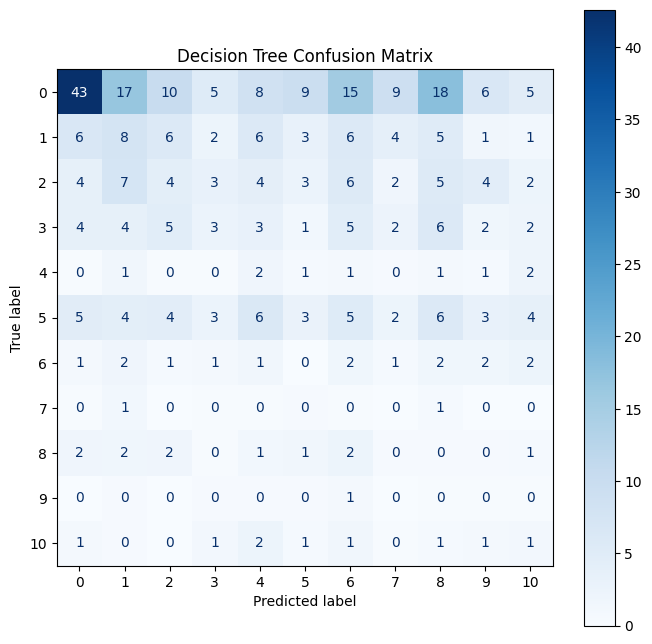

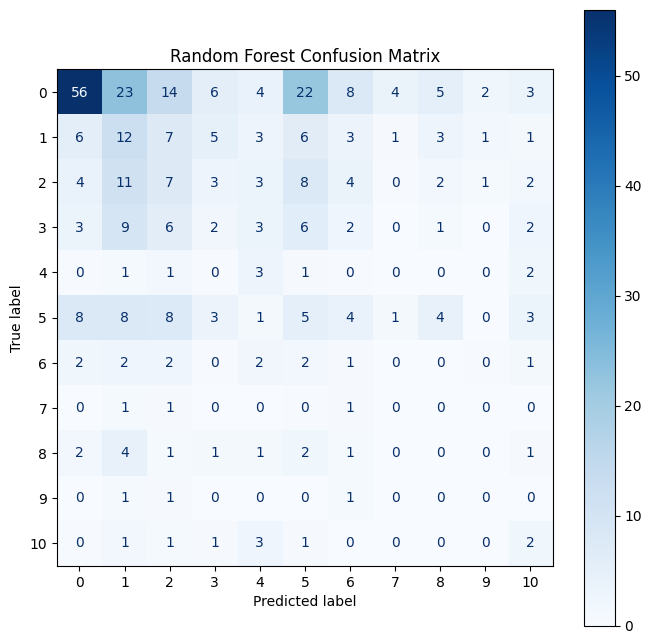

In [41]:
sum_test=np.sum(confMatrices_naiveBayes, axis=0)
sum_test=sum_test/5.0
plot_confusion_matrix(sum_test, title="Naive Bayes Confusion Matrix")

sum_test=np.sum(confMatrices_knn, axis=0)
sum_test=sum_test/5.0
plot_confusion_matrix(sum_test, title="KNN Confusion Matrix")

sum_test=np.sum(confMatrices_dTree, axis=0)
sum_test=sum_test/5.0
plot_confusion_matrix(sum_test, title="Decision Tree Confusion Matrix")


sum_test=np.sum(confMatrices_rForest, axis=0)
sum_test=sum_test/5.0
plot_confusion_matrix(sum_test, title="Random Forest Confusion Matrix")



In [42]:
del sum_test

In [44]:
#Naive Bayes
# Concatenate all DataFrames and take the mean
df_mean = pd.concat(report_dict_naiveBayes.values()).groupby(level=0).mean()
df_mean.index=["10_T02 M06 (VHM 309-12)  ", "11_T03 M06 (VHM 309-6)   ","9_T24 M06 (FRSURF50X5)   ","12_T06 M06 (VHM 309-3)   ", "13_T23 M06 (CHANF8)      ","3_T14 M06 (MECHE5.3)     ","4_T08 M06 (MECHE3.7 MD)  ","5_T09 M06 (MECHE4.6 MD)  ","6_T19 M06 (MECHE MD D4.8)","7_T10 M06 (MECHE5.5 MD)  ","8_T05 M06 (MECHE MD D5.8)", "accuracy", "macro avg", "weighted avg"]
print("Classification Report for Naive Bayes")
print(df_mean.sort_index())
del df_mean
#KNN
# Concatenate all DataFrames and take the mean
df_mean = pd.concat(report_dict_knn.values()).groupby(level=0).mean()
df_mean.index=["10_T02 M06 (VHM 309-12)  ", "11_T03 M06 (VHM 309-6)   ","9_T24 M06 (FRSURF50X5)   ","12_T06 M06 (VHM 309-3)   ", "13_T23 M06 (CHANF8)      ","3_T14 M06 (MECHE5.3)     ","4_T08 M06 (MECHE3.7 MD)  ","5_T09 M06 (MECHE4.6 MD)  ","6_T19 M06 (MECHE MD D4.8)","7_T10 M06 (MECHE5.5 MD)  ","8_T05 M06 (MECHE MD D5.8)", "accuracy", "macro avg", "weighted avg"]
print("Classification Report for KNN")
print(df_mean.sort_index())
del df_mean
#Decision Tree
# Concatenate all DataFrames and take the mean
df_mean = pd.concat(report_dict_dTree.values()).groupby(level=0).mean()
df_mean.index=["10_T02 M06 (VHM 309-12)  ", "11_T03 M06 (VHM 309-6)   ","9_T24 M06 (FRSURF50X5)   ","12_T06 M06 (VHM 309-3)   ", "13_T23 M06 (CHANF8)      ","3_T14 M06 (MECHE5.3)     ","4_T08 M06 (MECHE3.7 MD)  ","5_T09 M06 (MECHE4.6 MD)  ","6_T19 M06 (MECHE MD D4.8)","7_T10 M06 (MECHE5.5 MD)  ","8_T05 M06 (MECHE MD D5.8)", "accuracy", "macro avg", "weighted avg"]
print("Classification Report for Decision tree")
print(df_mean.sort_index())
del df_mean
#Random Forest
# Concatenate all DataFrames and take the mean
df_mean = pd.concat(report_dict_rForest.values()).groupby(level=0).mean()
df_mean.index=["10_T02 M06 (VHM 309-12)  ", "11_T03 M06 (VHM 309-6)   ","9_T24 M06 (FRSURF50X5)   ","12_T06 M06 (VHM 309-3)   ", "13_T23 M06 (CHANF8)      ","3_T14 M06 (MECHE5.3)     ","4_T08 M06 (MECHE3.7 MD)  ","5_T09 M06 (MECHE4.6 MD)  ","6_T19 M06 (MECHE MD D4.8)","7_T10 M06 (MECHE5.5 MD)  ","8_T05 M06 (MECHE MD D5.8)", "accuracy", "macro avg", "weighted avg"]
print("Classification Report for Random Forest")
print(df_mean.sort_index())
del df_mean


Classification Report for Naive Bayes
                           precision    recall  f1-score     support
10_T02 M06 (VHM 309-12)     0.802915  0.334247  0.471008  146.000000
11_T03 M06 (VHM 309-6)      0.123896  0.020833  0.035494   48.000000
12_T06 M06 (VHM 309-3)      0.055844  0.018182  0.026025   44.000000
13_T23 M06 (CHANF8)         0.126333  0.194286  0.152112   35.000000
3_T14 M06 (MECHE5.3)        0.041174  0.311111  0.072365    9.000000
4_T08 M06 (MECHE3.7 MD)     0.149728  0.093333  0.113048   45.000000
5_T09 M06 (MECHE4.6 MD)     0.042977  0.092308  0.057962   13.000000
6_T19 M06 (MECHE MD D4.8)   0.012500  0.066667  0.021053    3.000000
7_T10 M06 (MECHE5.5 MD)     0.021350  0.050000  0.029874   12.000000
8_T05 M06 (MECHE MD D5.8)   0.014286  0.066667  0.023529    3.000000
9_T24 M06 (FRSURF50X5)      0.042355  0.266667  0.072172    9.000000
accuracy                    0.188011  0.188011  0.188011    0.188011
macro avg                   0.130305  0.137664  0.097695  367.000

In [43]:
del DecisionTreeClassifier, GaussianNB, KNeighborsClassifier, RandomForestClassifier
del x_test_features, x_train_features, y_test, y_train, X_test_scaled, X_train_scaled, scaler, conf_matrix, myNpy, ordered_labels

## Saving the results in .csv files

In [46]:
for i, matrix in enumerate(confMatrices_dTree):
    df = pd.DataFrame(matrix)
    df.to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/confusion_matrix_DTree_fold_{i+1}.csv", index=False)
for i, matrix in enumerate(confMatrices_knn):
    df = pd.DataFrame(matrix)
    df.to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/confusion_matrix_knn_fold_{i+1}.csv", index=False)
for i, matrix in enumerate(confMatrices_naiveBayes):
    df = pd.DataFrame(matrix)
    df.to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/confusion_matrix_naiveBayes_fold_{i+1}.csv", index=False)
for i, matrix in enumerate(confMatrices_rForest):
    df = pd.DataFrame(matrix)
    df.to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/confusion_matrix_rForest_fold_{i+1}.csv", index=False)


In [45]:
for i, report in enumerate(report_dict_dTree):
    report_dict_dTree[report].to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/Report_DTree_Fold_{i+1}.csv", index=True)
for i, report in enumerate(report_dict_knn):
    report_dict_knn[report].to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/Report_KNN_Fold_{i+1}.csv", index=True)
for i, report in enumerate(report_dict_naiveBayes):
    report_dict_naiveBayes[report].to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/Report_NaiveBayes_Fold_{i+1}.csv", index=True)
for i, report in enumerate(report_dict_rForest):
    report_dict_rForest[report].to_csv(f"F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/Report_RForest_Fold_{i+1}.csv", index=True)
myResults.to_csv("F:/Data_BachelorHES/5.Dataset_preparation/4.ML_Results/Results_BasicModels.csv", index=False)

# TEST PCA / T-SNE ON FEATURES FOR FOLD 0

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


def x_loading_pading(subsetXTrainFiles, myDir):
    #Takes a list of files and returns a numpy array of shape (nObservations, nChannels, nSamples)
    X_subset=[]
    
    for file in subsetXTrainFiles:    
        myArray=np.load(os.path.join(myDir, file))
        myArray=np.transpose(DataUtils.padTruncate(myArray, maxTime=5001.24, fs=50000)[2])#align size of files to standard size of 250062 samples
        X_subset.append(myArray)
    X_subset=np.array(X_subset) #X_subset.shape (1989 observations, 4 channels :sound, accel X,Y,Z, 250062 samples per observation)
    
    return X_subset

def fit_scalers(X_train):
    """
    Initialise et entraîne des RobustScaler pour chaque canal à partir des données Train.
    Retourne une liste de scalers.
    """
    nChannels = X_train.shape[1]
    scalers = [RobustScaler() for _ in range(nChannels)]
    
    for ch in range(nChannels):
        X_train[:, ch, :] = scalers[ch].fit_transform(X_train[:, ch, :])  # Fit + transform sur Train
    
    return scalers, X_train  # Retourne les scalers et les données scalées

def apply_scaling(X_test, scalers):
    """
    Applique les scalers appris sur Train aux données de Test.
    Retourne les données Test scalées.
    """
    X_test_scaled = np.copy(X_test)  # Éviter de modifier les données originales
    nChannels = X_test.shape[1]
    
    for ch in range(nChannels):
        X_test_scaled[:, ch, :] = scalers[ch].transform(X_test_scaled[:, ch, :])  # Seulement transform
    
    return X_test_scaled

def pca_fitting(n_pca_max, X_scaled, measType=['Sound', 'AccelX', 'AccelY', 'AccelZ']):
    # n_pca_max : maximum number of PCA components
    # X_scaled : scaled data of shape (nObservations, nChannels, nSamples)
    #return pca_models which is a list of PCA models, one per channel ready to be fitted
    nChannels=X_scaled.shape[1]
    pca_models = [PCA(n_components=n_pca_max) for _ in range(nChannels)]
    for ch in range(nChannels):
        print(f"PCA on Channels {measType[ch]}...")
        pca_models[ch].fit(X_scaled[:, ch, :]) # Fit PCA on each channel
    return pca_models


def pca_transforming(X_scaled, pca_models, channels=4, n_pca_components=100):
    # X_scaled : scaled data of shape (nObservations, nChannels, nSamples)
    # pca_models : list of PCA models, one per channel
    # channels : number of channels
    # n_pca_components : number of PCA components
    X_tot_pca = np.zeros((len(X_scaled), channels, n_pca_components), dtype=np.float32)  # Shape (1989, 4, 100)
    
    # Iterate over each observation in the subset
    for obs_idx, observation in enumerate(X_scaled):
        # Here 'observation' is a ndarray with shape (nChannel, nSamples)
        X_pca = np.zeros((channels, pca_models[0].components_.shape[0]), dtype=np.float32)  # (4, 50)
        # Itération sur chaque canal dans l'observation (axe 1)
        for chan_idx, channel in enumerate(observation):
            #Channel contains nSamples samples
            X_pca[chan_idx, :] = pca_models[chan_idx].transform(channel.reshape(1,-1))  # Application PCA
        
        X_tot_pca[obs_idx, :, :] = X_pca[:, :n_pca_components] 
    return X_tot_pca



PCA on Channels Sound...
PCA on Channels AccelX...
PCA on Channels AccelY...
PCA on Channels AccelZ...


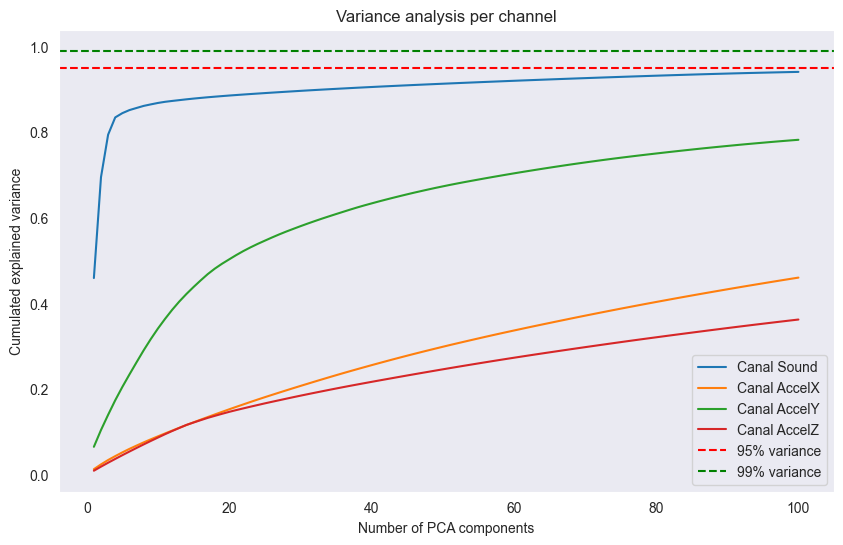

In [19]:


fold=0
measType=['Sound', 'AccelX', 'AccelY', 'AccelZ']
subsetXFiles=myGlobalDs[(myGlobalDs['Fold']==fold) & (myGlobalDs['Type']=="Train") ]['FilePath'].copy()


#Scaling
n_pca_max=100
X_train=x_loading_pading(subsetXFiles, myDir)
scalers, X_scaled=fit_scalers(X_train) 

#Models fitting
pca_models=pca_fitting(n_pca_max, X_scaled)

#PCA transformation
X_tot_pca=pca_transforming(X_scaled, pca_models, channels=4, n_pca_components=50)



# Concatenate of statistics and PCA components
nChannels=4
explained_variance_ratios = []
for ch in range(nChannels):
    explained_variance_ratios.append(np.cumsum(pca_models[ch].explained_variance_ratio_))  # cumulated variance ratio

#Trace variance ratio for each channel
plt.figure(figsize=(10, 6))
for ch in range(nChannels):
    plt.plot(range(1, n_pca_max+1), explained_variance_ratios[ch], label=f"Canal {measType[ch]}")

plt.axhline(y=0.95, color='r', linestyle='--', label="95% variance")
plt.axhline(y=0.99, color='g', linestyle='--', label="99% variance")
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulated explained variance")
plt.title("Variance analysis per channel")
plt.legend()
plt.grid()
plt.show()
del subsetXFiles, n_pca_max, X_train, nChannels, ch, scalers


In [20]:
del X_tot_pca

In [21]:
for i,ch in enumerate(explained_variance_ratios):
    print(f"Channel {measType[i]} explains : {ch[49]*100:.2f}% of variance with 50 components")
    
for i,ch in enumerate(explained_variance_ratios):
    print(f"Channel {measType[i]} explains : {ch[99]*100:.2f}% of variance with 100 components")
    
del i, ch 

Channel Sound explains : 91.30% of variance with 50 components
Channel AccelX explains : 29.92% of variance with 50 components
Channel AccelY explains : 67.34% of variance with 50 components
Channel AccelZ explains : 24.66% of variance with 50 components
Channel Sound explains : 94.06% of variance with 100 components
Channel AccelX explains : 46.07% of variance with 100 components
Channel AccelY explains : 78.22% of variance with 100 components
Channel AccelZ explains : 36.28% of variance with 100 components


In [ ]:
# Concaténation des statistiques et des composantes PCA
# X_scaled (1989, 4, 100) devient (1989, 400) après flatten
# pca_models - 4 pca models, 1 for each channel
scaler=RobustScaler()
x_train_features, _, y_train, __ = DataUtils.TrainTestFeaturesExtraction(myGlobalDs, fold, measType, myDir)
X_train_scaled=scaler.fit_transform(x_train_features)

X_tot_pca=pca_transforming(X_scaled, pca_models, channels=4, n_pca_components=100)
x_pca_flatten = X_tot_pca.reshape(X_tot_pca.shape[0], -1)  # Flatten : (1989, 400)
x_tsne_input = np.hstack((X_train_scaled, x_pca_flatten))  # Shape : (1989, 440)

# Vérification de la shape finale
print("Shape des données pour t-SNE :", x_tsne_input.shape)  # (1989, 440)

del x_train_features, X_train_scaled, X_tot_pca, x_pca_flatten, X_scaled, scaler, pca_models

In [26]:
x_tsne_input = np.hstack((X_train_scaled, x_pca_flatten))  # Shape : (1989, 440)

# Vérification de la shape finale
print("Shape des données pour t-SNE :", x_tsne_input.shape)  # (1989, 440)

del x_train_features, X_train_scaled, X_tot_pca, x_pca_flatten, X_scaled, scaler, pca_models

Shape des données pour t-SNE : (1989, 440)


C:\Users\Julie\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


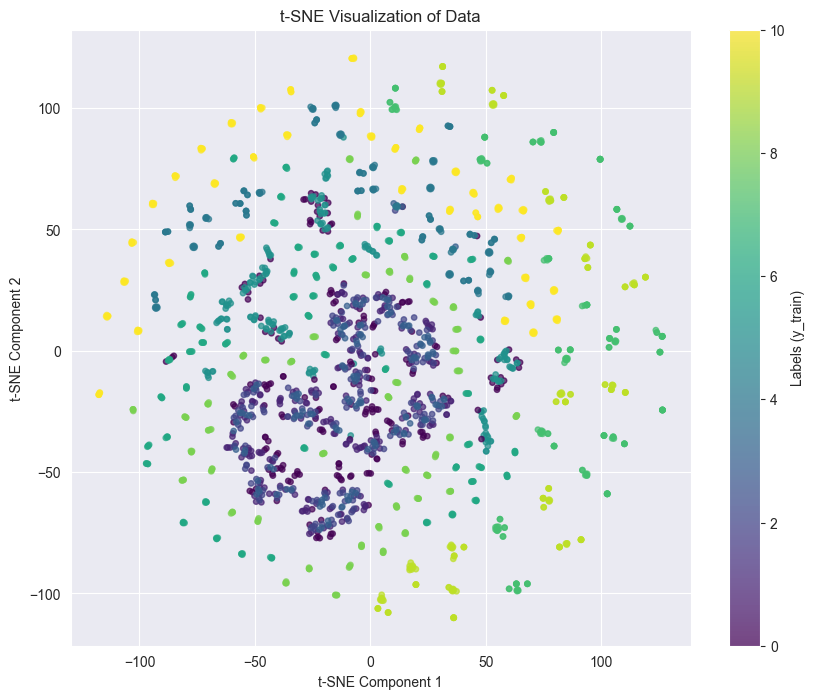

In [27]:
from sklearn.manifold import TSNE
# Application de t-SNE
tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, random_state=42)
x_tsne = tsne.fit_transform(x_tsne_input)  # Shape : (1989, 2)

# Visualisation des résultats
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train, cmap='viridis', s=15, alpha=0.7)
plt.colorbar(scatter, label="Labels (y_train)")
plt.title("t-SNE Visualization of Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

C:\Users\Julie\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


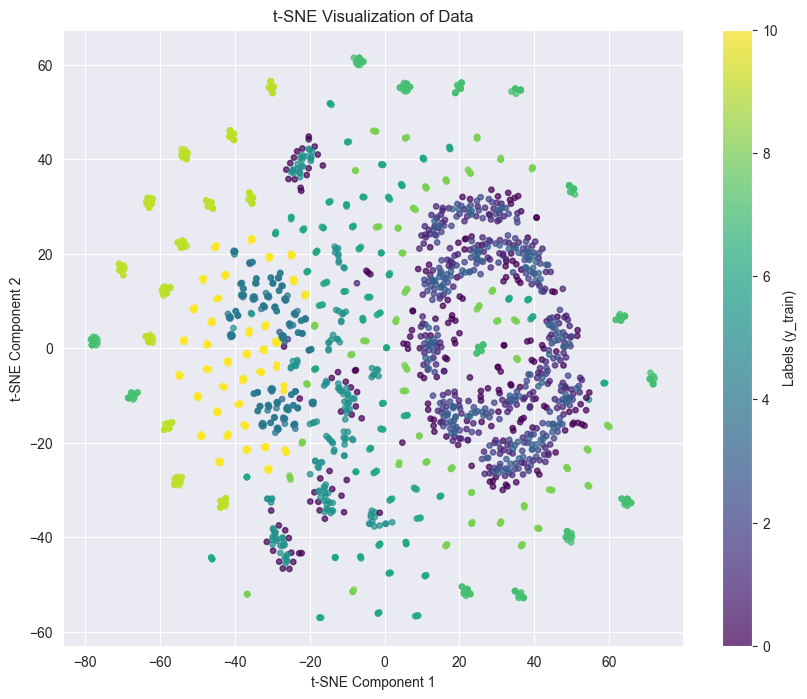

In [28]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
x_tsne = tsne.fit_transform(x_tsne_input)  # Shape : (1989, 2)

# Visualisation des résultats
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train, cmap='viridis', s=15, alpha=0.7)
plt.colorbar(scatter, label="Labels (y_train)")
plt.title("t-SNE Visualization of Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

C:\Users\Julie\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


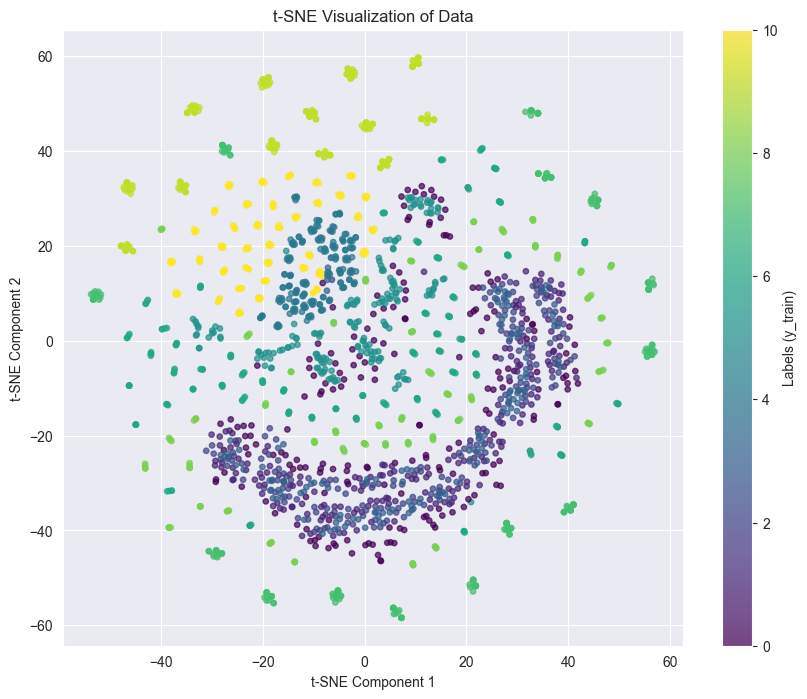

In [29]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, random_state=42)
x_tsne = tsne.fit_transform(x_tsne_input)  # Shape : (1989, 2)

# Visualisation des résultats
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train, cmap='viridis', s=15, alpha=0.7)
plt.colorbar(scatter, label="Labels (y_train)")
plt.title("t-SNE Visualization of Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

del tsne, x_tsne, x_tsne_input

In [30]:
del scatter, fold, y_train

# PCA ON FEATURES FOR ALL FOLDS


In [38]:

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


conf_matrices = []  # Liste pour stocker les matrices de confusion
report_dict = {}  # Dictionnaire pour stocker les rapports par fold

nFold=5
n_pca_max=100
scaler=RobustScaler()
measType=['Sound', 'AccelX', 'AccelY', 'AccelZ']
for fold in range(nFold):
    
    
    print(f"Fold {(fold+1)}/{nFold} - Starting")
    #Loading of train files
    subsetXTrainFiles=myGlobalDs[(myGlobalDs['Fold']==fold) & (myGlobalDs['Type']=="Train") ]['FilePath'].copy()
 
    #Loading, Padding and Scaling 
    X_Train=x_loading_pading(subsetXTrainFiles, myDir)
    scalers, X_Train_scaled=fit_scalers(X_Train)
    print(f"Fold {(fold+1)}/{nFold} - scaling done")
    
    #Models fitting on train files
    pca_models=pca_fitting(n_pca_max, X_Train_scaled)
    
    #PCA transformation
    X_train_pca=pca_transforming(X_Train_scaled, pca_models, channels=4, n_pca_components=n_pca_max)
    del X_Train, X_Train_scaled, subsetXTrainFiles    
    #Loading of test files
    subsetXTestFiles = myGlobalDs[(myGlobalDs['Fold'] == fold) & (myGlobalDs['Type'] == "Test")]['FilePath'].copy()
    X_Test = x_loading_pading(subsetXTestFiles, myDir)

    # Apply scalers from Train on Test so only trnsform, no refit.
    X_Test_scaled = apply_scaling(X_Test, scalers)
    
    # PCA Transformation on Test
    X_test_pca = pca_transforming(X_Test_scaled, pca_models, channels=4, n_pca_components=n_pca_max)
    print(f"Fold {(fold+1)}/{nFold} - PCA Transformation done")
    del X_Test, X_Test_scaled, subsetXTestFiles, pca_models, scalers
    
    # Import of statistical features and scaling
    x_train_features, x_test_features, y_train, y_test = DataUtils.TrainTestFeaturesExtraction(myGlobalDs, fold, measType, myDir)
    X_stat_train_scaled=scaler.fit_transform(x_train_features)
    X_stat_test_scaled=scaler.transform(x_test_features)
    del x_train_features, x_test_features
    
    #Flattening of features 
    x_train_pca_flat = X_train_pca.reshape(X_train_pca.shape[0], -1)  # Flatten : (1989, 400)
    x_test_pca_flat = X_test_pca.reshape(X_test_pca.shape[0], -1)  # Flatten : (1989, 400)
    print(f"Fold {(fold+1)}/{nFold} - Flattening done")
    #Concatenate PCA and statistics
    X_train_combined = np.hstack((x_train_pca_flat, X_stat_train_scaled))  # (1989, 440)
    X_test_combined = np.hstack((x_test_pca_flat, X_stat_test_scaled))  # (test_size, 440)
    del x_train_pca_flat, x_test_pca_flat, X_stat_train_scaled, X_stat_test_scaled, X_train_pca, X_test_pca
    #Starting training of random forest
    print(f"Fold {(fold+1)}/{nFold} - Starting Random Forest")
    
    # Initialisation du modèle
    clf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Entraînement du modèle
    clf.fit(X_train_combined, y_train)

    # Prédictions
    y_pred = clf.predict(X_test_combined)

    # Évaluation du modèle
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)  # Dictionnaire contenant Precision, Recall, F1-score
    report_df=pd.DataFrame(report).transpose()
    report_dict[f"Fold {fold}"]=report_df
    conf_matrix = confusion_matrix(y_test, y_pred)  # Matrice de confusion

    # 🔹 Stockage des résultats dans le DataFrame
    df_fold=pd.DataFrame([{
        "Fold": fold+1,
        "Accuracy": acc,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-score": report["weighted avg"]["f1-score"],
        "Support": report["weighted avg"]["support"]
    }])
    if fold==0:
        df_results=df_fold
    else:
        df_results=pd.concat([df_results, df_fold], ignore_index=True)

    conf_matrices.append(conf_matrix)  # Stocker la matrice de confusion pour analyse
    # Évaluation du modèle
    print("Accuracy :", acc)
    print("Report weighted average :", report["weighted avg"])
    del  X_train_combined, X_test_combined, y_pred, clf, df_fold, report, report_df, acc, conf_matrix
    

del nFold, fold



Fold 1/5 - Starting
Fold 1/5 - scaling done
PCA on Channels Sound...
PCA on Channels AccelX...
PCA on Channels AccelY...
PCA on Channels AccelZ...
Fold 1/5 - PCA Transformation done
Fold 1/5 - Flattening done
Fold 1/5 - Starting Random Forest
Accuracy : 0.6948228882833788
Report weighted average : {'precision': 0.7412588940688121, 'recall': 0.6948228882833788, 'f1-score': 0.6816558284813629, 'support': 367.0}
Fold 2/5 - Starting
Fold 2/5 - scaling done
PCA on Channels Sound...
PCA on Channels AccelX...
PCA on Channels AccelY...
PCA on Channels AccelZ...
Fold 2/5 - PCA Transformation done
Fold 2/5 - Flattening done
Fold 2/5 - Starting Random Forest
Accuracy : 0.6839237057220708
Report weighted average : {'precision': 0.7329151356220353, 'recall': 0.6839237057220708, 'f1-score': 0.6721442300545764, 'support': 367.0}
Fold 3/5 - Starting
Fold 3/5 - scaling done
PCA on Channels Sound...
PCA on Channels AccelX...
PCA on Channels AccelY...
PCA on Channels AccelZ...
Fold 3/5 - PCA Transformati

In [39]:
# save results
df_results.to_csv("F:\Data_BachelorHES\DataSet_CNC\Results\Results_PCA_Compact.csv", index=False)


In [46]:
import pandas as pd

for i, matrix in enumerate(conf_matrices):
    df = pd.DataFrame(matrix)
    df.to_csv(f"F:\Data_BachelorHES\DataSet_CNC\Results\confusion_matrix_PCA_fold_{i+1}.csv", index=False)
del i, matrix

In [47]:
myResults.to_csv("F:\Data_BachelorHES\DataSet_CNC\Results\Results_BasicModels.csv", index=False)


In [48]:
for i, report in enumerate(report_dict):
    report_dict[report].to_csv(f"F:\Data_BachelorHES\DataSet_CNC\Results\Reports_PCA_Fold_{i+1}.csv", index=True)
del i, report